In [1]:
#Imports and dependencies
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

from os.path import join, abspath, dirname
import sys
sys.path.insert(0, abspath(join("..", dirname(os.getcwd()))))
          
import random
import torch
from PIL import Image, ImageOps
from tqdm import tqdm_notebook
from skimage import img_as_ubyte
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.io import load_obj, save_obj
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency
)
from pytorch3d.renderer import (
    SfMPerspectiveCameras, RasterizationSettings, MeshRenderer, MeshRasterizer, 
    BlendParams, SoftSilhouetteShader, SoftPhongShader, PointLights, TexturesVertex, 
    TexturesAtlas, HardPhongShader, HardFlatShader
)
from pytorch3d.io import load_objs_as_meshes

from dataclasses import dataclass, field, asdict, astuple

import numpy as np
#Plotting Libs
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl


from trajectory import cam_trajectory
from mesh import (
    load_meshes, mesh_random_translation, rotate_mesh_around_axis, 
    translate_mesh_on_axis, scale_mesh
)
from event_renderer import generate_event_frames

from utils.visualization import plot_trajectory_cameras
from utils.manager import RenderManager, ImageManager

In [2]:

mpl.rcParams['savefig.dpi'] = 150
mpl.rcParams['figure.dpi'] = 150
#Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)

### PARAMS

In [8]:
@dataclass
class RenderParams:
    
    img_size: int = (560, 560)
    sigma_hand: float = .15
    
    #Size of the dataset
    mini_batch: int = 72
    batch_size: int = 360
    mesh_iter: int = 1
        
    show_frame: bool = False

### Create a Renderer

In [4]:
cameras = SfMPerspectiveCameras(device=device)

# To blend the 100 faces we set a few parameters which control the opacity and the sharpness of 
# edges. Refer to blending.py for more details. 
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 256x256. To form the blended image we use 100 faces for each pixel. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size= RenderParams.img_size[0], 
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=100, 
)

# Create a silhouette mesh renderer by composing a rasterizer and a shader. 
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)


# We will also create a phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=RenderParams.img_size[0], 
    blur_radius=1e-5, 
    faces_per_pixel=100, 
)
# We can add a point light in front of the object. 
#lights = PointLights(device=device, location=((2., 2.0, 2.0),))
lights = PointLights(
    device=device, 
    location=[[3.0, 3.0, 0.0]], 
    diffuse_color=((1.0, 1.0, 1.0),),
    specular_color=((1.0, 1.0, 1.0),),
)

phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardFlatShader(device=device, lights=lights, cameras=cameras)
)

WARNING, Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


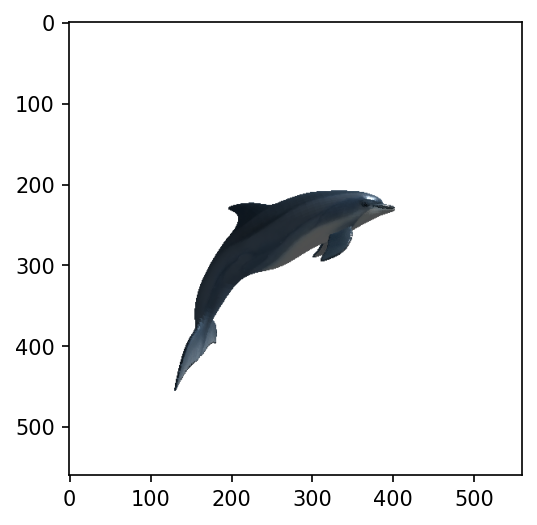

In [5]:
# Load obj file
path = "../data/meshes/dolphin/dolphin.obj"
mesh = load_objs_as_meshes([path], create_texture_atlas=False,load_textures=True, device=device)
#mesh.textures = TexturesVertex(
#                verts_features=torch.ones_like(mesh.verts_padded(), device=device)
#            )

verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center.expand(N, 3))
mesh.scale_verts_((1.0 / float(scale)));


mesh = rotate_mesh_around_axis(mesh, [90,90,180], phong_renderer,dist=2, device=device)
#mesh = translate_mesh_on_axis(mesh, [0,-20,-50], phong_renderer, dist=5)
#verts, faces = mesh.get_mesh_verts_faces(0)
#save_obj("../data/meshes/plane_WWII/plane_WWII.obj", verts, faces)


In [6]:
def merge_with_background(image, background = None, show: bool = False):

    def background_generator():
            files = []
            background_folder = "../data/sun360"
            files = os.listdir(background_folder)
            rand_file = random.randint(0, len(files) - 1)
            rand_file_path = abspath(join(background_folder, files[rand_file]))
            files = os.listdir(rand_file_path)
            for img_num in range(len(files)):
                path_img = join(rand_file_path, f"{img_num}.jpg")
                img = Image.open(path_img).resize(RenderParams.img_size)
                yield np.array(img).astype(np.uint8)
    
    if background is None:
        background = background_generator()

    #Image.fromarray((np.array(image) * 255).astype(np.uint8)).save("test.png")
    #image = Image.open("test.png")
    
    image = img_as_ubyte(np.clip(image,0, 1))[...,:3]
    
    image = np.array(image).astype(np.uint8)
    
    try:
        image_bg = next(background)
    except StopIteration:
        background = background_generator()
        image_bg = next(background)

    #image_thresh = (image > 1) * 255

    image_white = np.all(image==[255,255,255], axis=-1)
    image[image_white] = image_bg[image_white]
    #img_add = np.amin((image_bg + image), 255)
    #img_add[img_add > 255] = 255
    
    if show:
        plt.imshow(image)
        plt.show()
        
    return image, background


### Data Creation Loop

In [9]:
renders = {
    "phong": None,
    "silhouette": None,
    "events": None
}
variation = ["dist", "elev"]
pepper = ["elev"]
random_start = ["azim"]

#meshes = load_meshes()
# Set paths
DATA_DIR = "../data/meshes"
obj_filename = os.path.join(DATA_DIR, "dog/dog.obj")

# Load obj file
#mesh = load_objs_as_meshes([obj_filename], device=device)

name = "dolphin"
#Iterate over each mesh
#for name, mesh in meshes.items():
    
"""Augmentation scenarios (all trajectories complete full 360 w/ simulated handshake)
    -normal trajectory
    -varying distance
    -
"""
count = 0
while count != RenderParams.mesh_iter:

    #Create a random trajectory
    cam_poses = cam_trajectory(
        variation,
        pepper,
        random_start,
        RenderParams.batch_size
    )

    mesh, translation = mesh_random_translation(mesh, .0, device=device)

    background = None

    render_manager = RenderManager(
        types=list(renders.keys()),
        mesh_name = name,
        new_folder = f"test_{name}",
        metadata = {
            "augmentation_params": {
                "variation": variation,
                "pepper": pepper,
                "random_start": random_start
            },
            "mesh_transformation": {
                "translation": translation.get_matrix().cpu().numpy().tolist()
            }
        }
    )
    render_manager.init()
    # Render the teapot providing the values of R and T.
    R, T = cam_poses
    for num in range(1, len(R) + 1):
        img_dict = {}

        if "phong" in renders.keys():
            image_ref = phong_renderer(meshes_world=mesh, R=R[num-1:num:], T=T[num-1:num:])
            image_ref = image_ref.cpu().numpy()
            img_dict["phong"] = image_ref.squeeze()
            

        if "silhouette" in renders.keys():
            """
            silhouette = silhouette_renderer(meshes_world=mesh, R=R[num-1:num:], T=T[num-1:num:])
            silhouette = silhouette.cpu().numpy()
            img_dict["silhouette"] = silhouette.squeeze()[...,3]
            """
            #Creating a mask from the image instead of using the silhouette renderer
            silhouette = np.clip(((img_dict["phong"][...,:3]).astype(np.uint8)) * 255, 0 , 255)
            silhouette = (silhouette < 1) * 255
            img_dict["silhouette"] = silhouette

        #Merge with background images
        img, background = merge_with_background(img_dict["phong"], background, show=False)
        img_dict["phong"] = img
        if RenderParams.show_frame:
            for plot_num, img in enumerate(img_dict.values()):
                plot_num += 1
                ax = plt.subplot(1, len(img_dict.values()), plot_num)
                ax.imshow(img)
            plt.show()

        render_manager.add_images( 
            num,
            img_dict,
            R[num-1:num:], T[num-1:num:])

    image_path_list = [img['image_path'] for img in render_manager.images['phong']]
    event_frames = generate_event_frames(image_path_list, RenderParams.img_size, RenderParams.mini_batch)
    for num, frame in enumerate(event_frames):
        render_manager.add_event_frame(num, frame)

    render_manager.close()
    count += 1


INFO, Render Manager started in base file /home/alexis/e3d/e3d/data/renders/test_dolphin/002-dolphin_2020-09-23T11:45:50
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppre

WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to

WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to

WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to

WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to

WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
WARNING, Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to